In [1]:
%cd /content/drive/MyDrive/dslab/ds-lab-2022-p2-cyclone/

[Errno 2] No such file or directory: '/content/drive/MyDrive/dslab/ds-lab-2022-p2-cyclone/'
/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load test data ==================================================
test_path = 'datasets/test_N_extra_extreme'
train_path = 'datasets/train_N_extra_normal'
test_labels = pd.read_pickle(test_path + "/labels.pkl")  
test_meta = pd.read_pickle(test_path + "/meta_features.pkl")    
test_ra = pd.read_pickle(test_path + "/ra_features.pkl")
scaler_dict = pd.read_pickle(train_path + "/scaler_dict.pkl")

BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.MSELoss()

print("Using {} to process".format(device))

# flatten the ra features for shap explainer
test_dataset = CycloneDataset(test_meta, test_ra, test_labels, device)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

# load the model to explain
save_path = 'datasets/checkpoints/GRU_TCN_extreme_test_100.tar'
checkpoint = torch.load(save_path, map_location="cuda")
args = checkpoint['args']

model = TCN_GRU(**args).to("cuda")
model.load_state_dict(checkpoint['model_state_dict']) 

denorm_model_loss, denorm_model_loss_ts = evaluate_denorm(model, test_loader, loss_fn, scaler_dict, init_h = True)
model_loss, model_loss_ts = evaluate(model, test_loader, loss_fn, init_h = True)
print("====================Compare on test set:===============================")
print(f"Over all timestep: \n GRU_CNN normed MSE: {model_loss} \n GRU_CNN denormed MSE {denorm_model_loss}")
print(f"By each timestep: \n GRU_CNN normed MSE: {model_loss_ts} \n GRU_CNN denormed MSE: {denorm_model_loss_ts}")

Using cuda to process
====================Compare on test set:===============================
Over all timestep: 
 GRU_CNN normed MSE: 0.1641474437068726 
 GRU_CNN denormed MSE 26.15312561082958
By each timestep: 
 GRU_CNN normed MSE: [0.14363818 0.1472058  0.15492053 0.16643321 0.17897236 0.19371455] 
 GRU_CNN denormed MSE: [22.88544552 23.45386402 24.68302903 26.5173095  28.5151357  30.86396516]


In [5]:
# ensure to have this SHAP version installed!
!pip install https://github.com/ceshine/shap/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 58.0 MB 633 kB/s
  Created wheel for shap: filename=shap-0.25.0-cp37-cp37m-linux_x86_64.whl size=265833 sha256=a3e6b91509d755f9cedbcd3cd9e7f9bf7ada415dc2dcf3584e231d66ae419e34
  Stored in directory: /tmp/pip-ephem-wheel-cache-aswwy6wm/wheels/31/37/aa/3c8128c223d18538949079a4840acebf4aadac7319fb10a5b9
Successfully built shap


In [8]:
import torch
from torch import nn, transpose
from torch.utils.data import DataLoader
import os
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import shap
import seaborn as sns; sns.set_theme()

from model import TCN_GRU, TCN_GRU_SHAP
from loaddata import CycloneDataset, CycloneDatasetSHAP
from utils import moving_average, MSELoss_denorm
from train import train, evaluate_denorm, evaluate

### Plot learning curve

In [ ]:
# plot learning curve
def plot_learning(loss_dict):
  n_epochs = len(loss_dict['val'])
  x_epoch = [int(i+1) for i in range(n_epochs)]
  train = loss_dict['train']
  val = loss_dict['val']
  train = [i.to(torch.device("cpu")).detach().numpy() for i in train]
  plt.plot(x_epoch, train, label = 'train')
  plt.plot(x_epoch, val, label = 'val')
  plt.legend(loc = 'best')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.show()

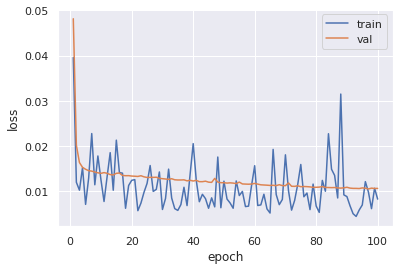

In [ ]:
loss_dict = pd.read_pickle("datasets/loss_dicts/GRU_CNN_100.pkl")
plot_learning(loss_dict)

### SHAP Feature importance

In [5]:
# load test data
test_path = 'datasets/test_N_extra'
train_path = 'datasets/train_N_extra'

train_meta = pd.read_pickle(train_path + "/train_meta.pkl")
train_ra = pd.read_pickle(train_path + "/train_ra.pkl")
train_labels = pd.read_pickle(train_path + "/train_labels.pkl")


test_labels = pd.read_pickle(test_path + "/labels.pkl")  
test_meta = pd.read_pickle(test_path + "/meta_features.pkl")    
test_ra = pd.read_pickle(test_path + "/ra_features.pkl")

# flatten the ra features for shap explainer
test_dataset = CycloneDatasetSHAP(test_meta, test_ra, test_labels, "cpu")
train_dataset = CycloneDatasetSHAP(train_meta, train_ra, train_labels, "cpu")

test_loader = DataLoader(test_dataset, batch_size = 200, shuffle = True)
train_loader = DataLoader(train_dataset, batch_size = 5000, shuffle = True)

In [6]:
# load the model to explain
save_path = 'datasets/checkpoints/GRU_TCN_100.tar'
checkpoint = torch.load(save_path, map_location="cpu")
args = checkpoint['args']
learning_rate = 1e-4 / 5

model = TCN_GRU_SHAP(args['input_size'], args['output_size'], args['num_channels'], args['kernel_size'], args['dropout'], args['hidden_size'], args['n_layers'], "cpu").to("cpu")
#model = TCN_GRU(**checkpoint['args']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
NUM_EPOCH = checkpoint['epoch']

In [9]:
args

{'device': device(type='cuda'),
 'dropout': 0.2,
 'hidden_size': 128,
 'input_size': 79,
 'kernel_size': 3,
 'n_layers': 8,
 'num_channels': [64, 64, 64],
 'output_size': 6}

In [15]:
bg_data = next(iter(train_loader))[0].to("cpu")
explain_data = next(iter(test_loader))[0].to("cpu")

In [16]:
%%time
model.init_hidden(5000)
e = shap.DeepExplainer(
        model, 
        bg_data,
        )

CPU times: user 2.61 s, sys: 90.5 ms, total: 2.7 s
Wall time: 674 ms


In [17]:
%%time
model.init_hidden(10000)
shap_values = e.shap_values(
    explain_data
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1023: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "


流式输出内容被截断，只能显示最后 5000 行内容。
CPU times: user 5h 41min 32s, sys: 7min 42s, total: 5h 49min 15s
Wall time: 1h 42min 15s


In [19]:
import pickle
pickle.dump(shap_values, open('datasets/outputs/shap_5000_200.pkl', "wb"))

In [12]:
# agg over all 6 previours time steps, to see the influence on each future prediction
def get_agg_shap_for_timestep(timestep, shap_abs):

  mean_0 = np.mean(shap_abs[timestep], axis=0) # contribution to the prediction of t+1

  # agg all month encoding into one feature
  mean_0_meta = np.concatenate((mean_0[:, :4],np.sum(mean_0[:, 4:15], axis = 1).reshape(-1, 1)), axis = 1) 

  # get ra feature importance of each timestep
  mean_0_ra = mean_0[:, 15:].reshape(-1, 7, 11, 11) 

  # concat each ra grid into one feature
  mean_0_ra_concat = np.sum(np.sum(mean_0[:, 15:].reshape(-1, 7, 11, 11), axis = 2), axis = 2) # dim 6*7

  mean_0_all_features = np.concatenate((mean_0_meta, mean_0_ra_concat), axis = 1)

  # agg over all 6 timesteps
  mean_0_all_features = np.mean(mean_0_all_features, axis = 0)

  return mean_0_all_features

# agg over the all future time steps, to see feature importance of each previours time step
def get_agg_shap_for_prev_timestep(shap_abs):

  for i in range(6):
    mean_0 = np.mean(shap_abs[i], axis=0) # 6 * 862

    # agg all month encoding into one feature
    mean_0_meta = np.concatenate((mean_0[:, :4],np.sum(mean_0[:, 4:15], axis = 1).reshape(-1, 1)), axis = 1) 

    # get ra feature importance of each timestep
    mean_0_ra = mean_0[:, 15:].reshape(-1, 7, 11, 11) 

    # concat each ra grid into one feature
    mean_0_ra_concat = np.sum(np.sum(mean_0[:, 15:].reshape(-1, 7, 11, 11), axis = 2), axis = 2) # dim 6*7

    mean_0_all_features = mean_0_all_features + np.concatenate((mean_0_meta, mean_0_ra_concat), axis = 1) if i > 0 else np.concatenate((mean_0_meta, mean_0_ra_concat), axis = 1)

  mean_0_all_features /= 6 # 6 * 12

  return mean_0_all_features

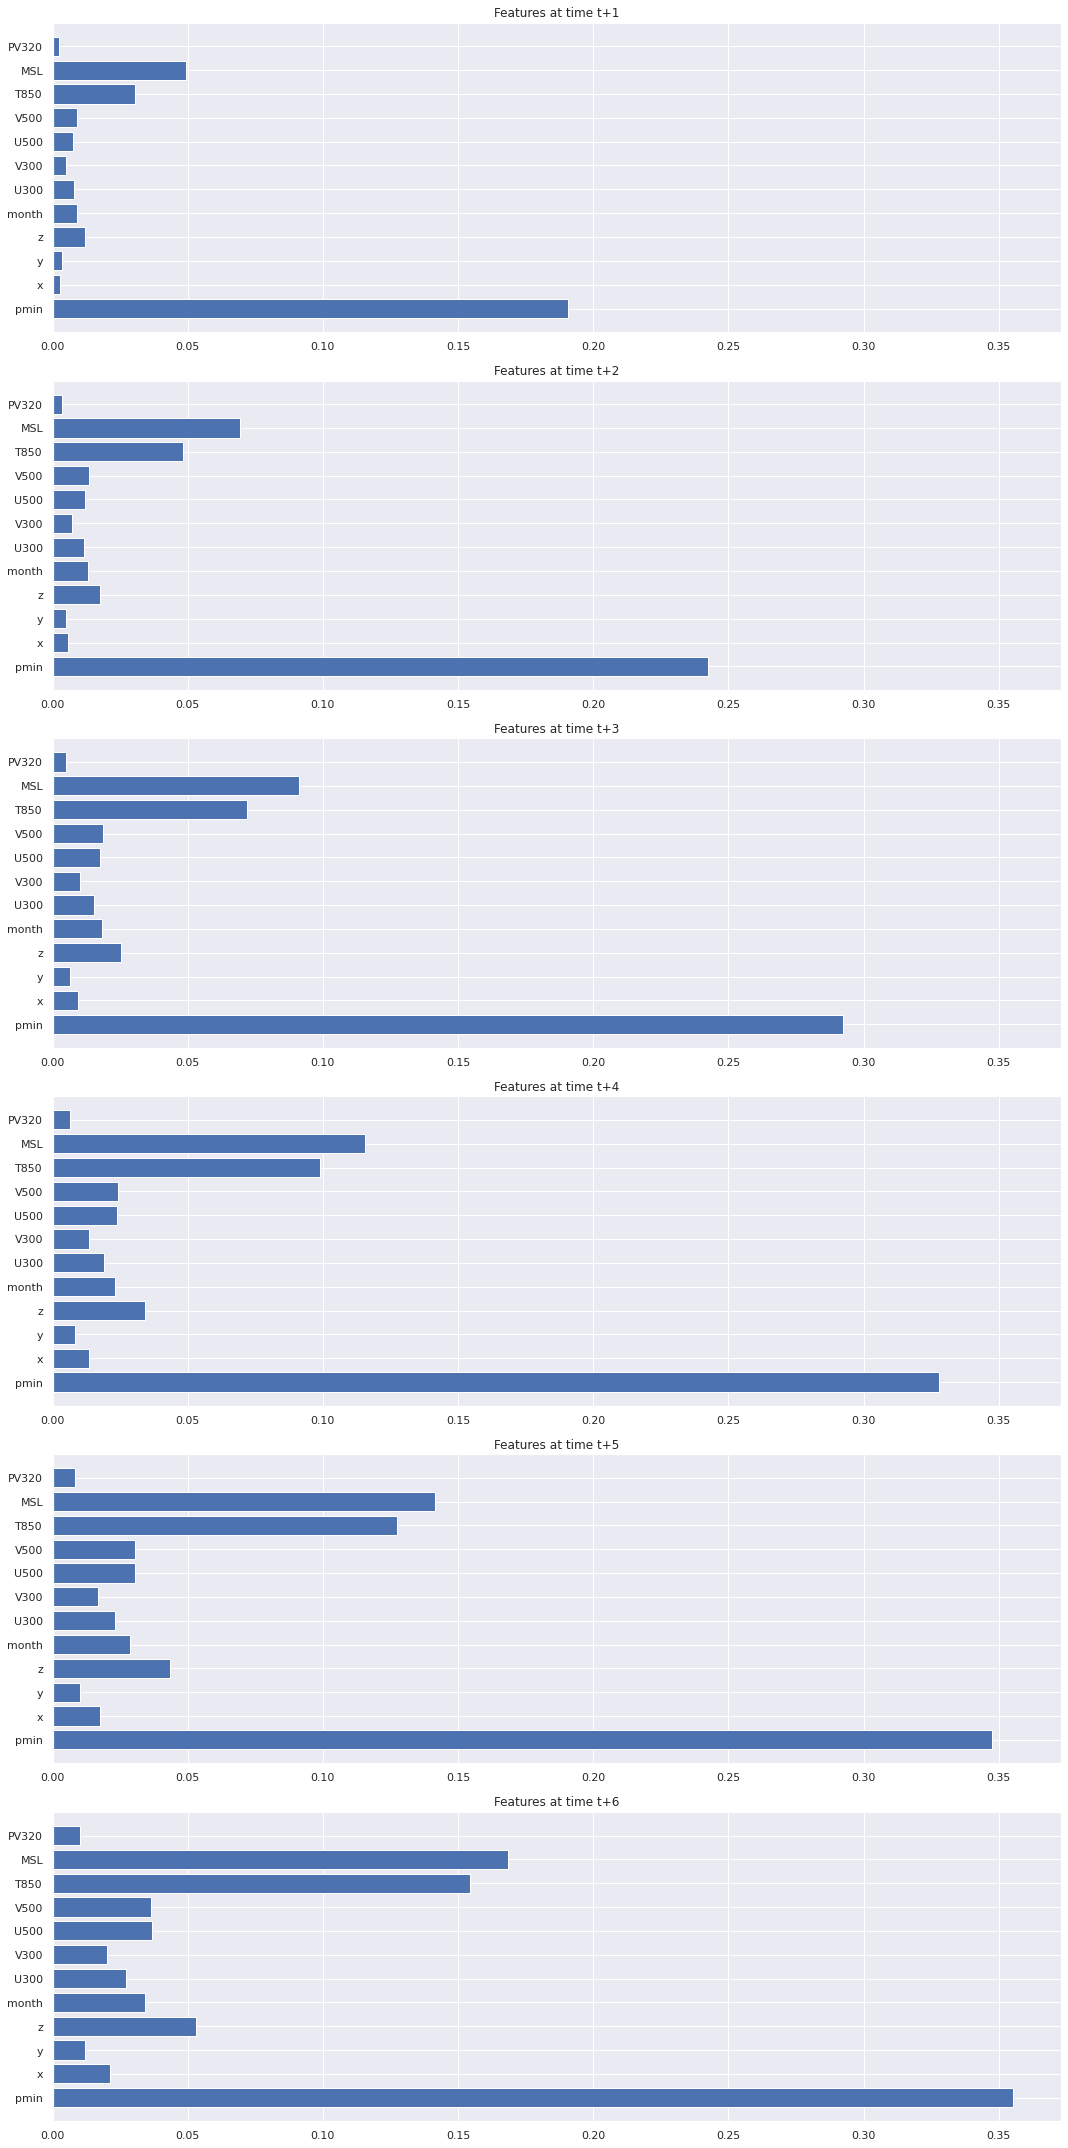

In [23]:
# plot bar chart for agg over previous time step
shap_values = pd.read_pickle('datasets/outputs/shap_5000_200.pkl')
shap_val = np.array(shap_values)
shap_abs = np.absolute(shap_val)
f_names = ['pmin', 'x', 'y', 'z', 'month', 'U300', 'V300', 'U500', 'V500', 'T850', 'MSL', 'PV320']
x_pos = [i for i, _ in enumerate(f_names)]

fig = plt.figure(figsize=(15, 30))
plt1 = fig.add_subplot(611)
plt1.barh(x_pos,get_agg_shap_for_timestep(0, shap_abs))
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title("Features at time t+1")

plt2 = fig.add_subplot(612,sharex=plt1)
plt2.barh(x_pos,get_agg_shap_for_timestep(1, shap_abs))
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t+2")

plt2 = fig.add_subplot(613,sharex=plt1)
plt2.barh(x_pos,get_agg_shap_for_timestep(2, shap_abs))
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t+3")

plt2 = fig.add_subplot(614,sharex=plt1)
plt2.barh(x_pos,get_agg_shap_for_timestep(3, shap_abs))
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t+4")

plt2 = fig.add_subplot(615,sharex=plt1)
plt2.barh(x_pos,get_agg_shap_for_timestep(4, shap_abs))
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t+5")

plt2 = fig.add_subplot(616,sharex=plt1)
plt2.barh(x_pos,get_agg_shap_for_timestep(5, shap_abs))
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t+6")
#plt2.set_xscale('log')

plt.tight_layout()
plt.show()

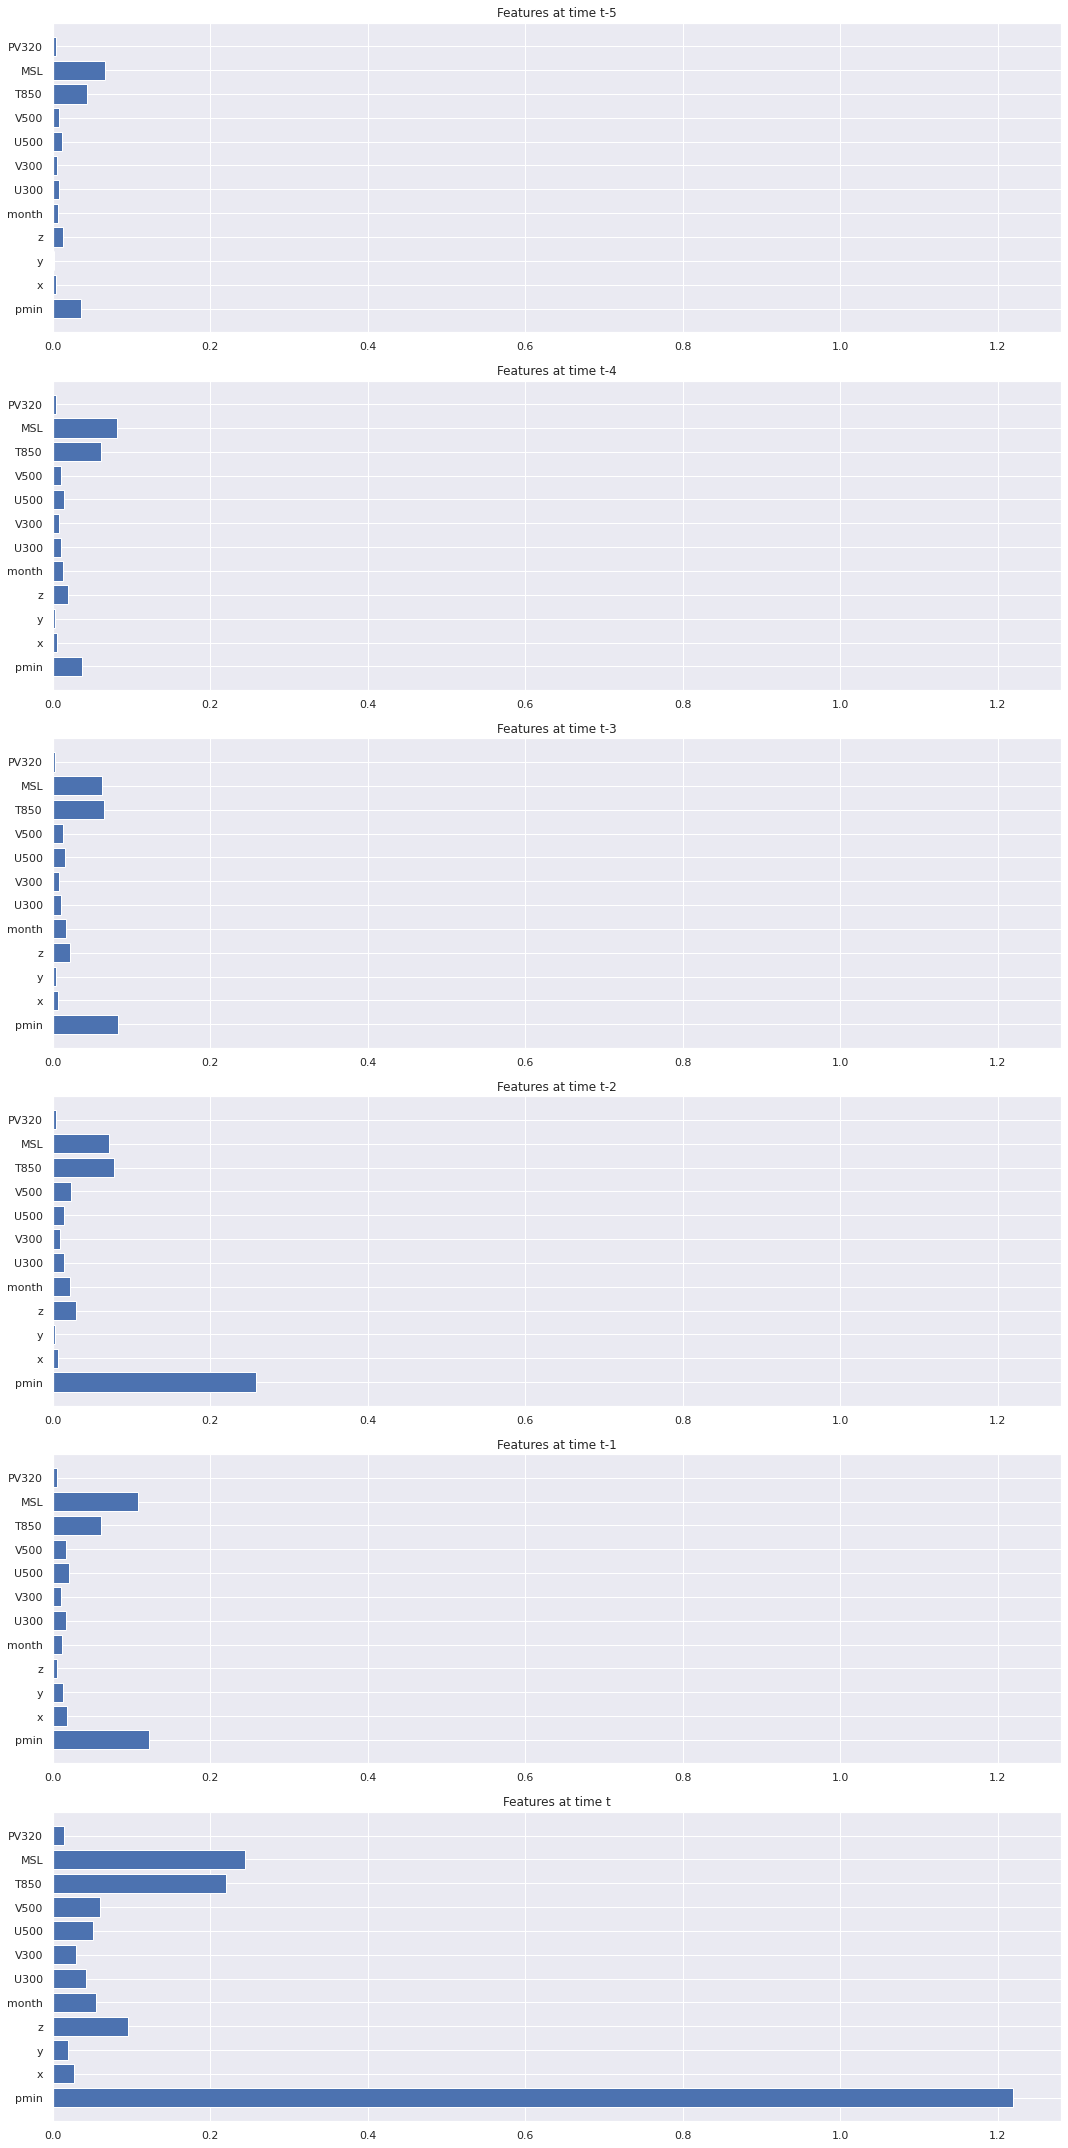

In [13]:
# plot bar chart for agg over future time step
shap_values = pd.read_pickle('datasets/outputs/shap_5000_200.pkl')
shap_val = np.array(shap_values)
shap_abs = np.absolute(shap_val)
f_names = ['pmin', 'x', 'y', 'z', 'month', 'U300', 'V300', 'U500', 'V500', 'T850', 'MSL', 'PV320']
x_pos = [i for i, _ in enumerate(f_names)]
f_imp = get_agg_shap_for_prev_timestep(shap_abs)

fig = plt.figure(figsize=(15, 30))
plt1 = fig.add_subplot(611)
plt1.barh(x_pos,f_imp[0])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title("Features at time t-5")

plt2 = fig.add_subplot(612,sharex=plt1)
plt2.barh(x_pos,f_imp[1])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t-4")

plt2 = fig.add_subplot(613,sharex=plt1)
plt2.barh(x_pos,f_imp[2])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t-3")

plt2 = fig.add_subplot(614,sharex=plt1)
plt2.barh(x_pos,f_imp[3])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t-2")

plt2 = fig.add_subplot(615,sharex=plt1)
plt2.barh(x_pos,f_imp[4])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t-1")

plt2 = fig.add_subplot(616,sharex=plt1)
plt2.barh(x_pos,f_imp[5])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Features at time t")
#plt2.set_xscale('log')

plt.tight_layout()
plt.show()

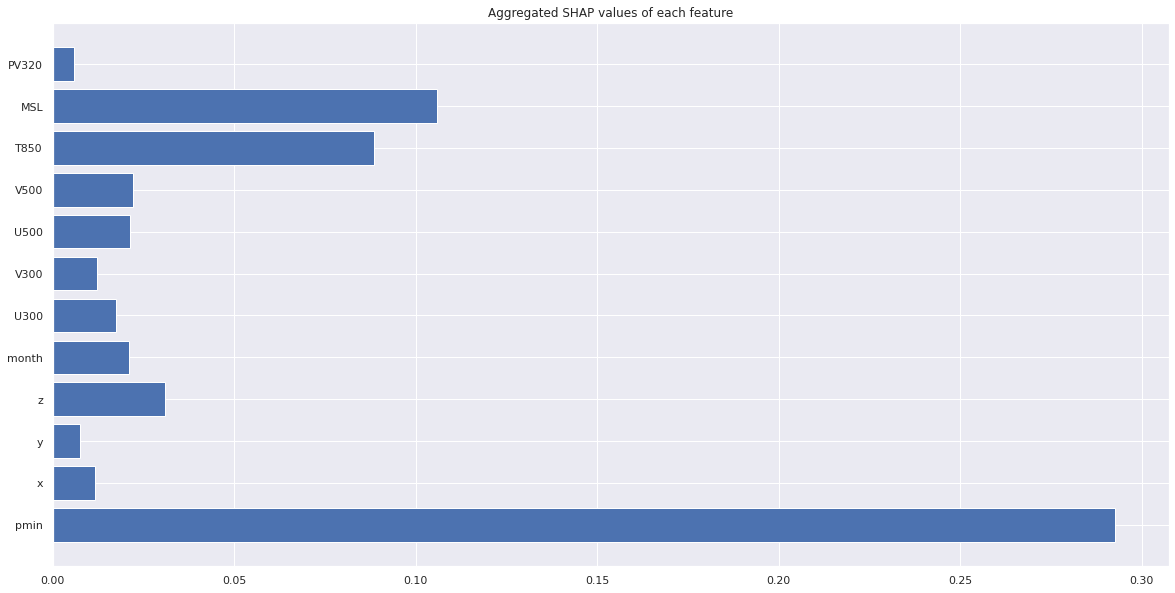

In [75]:
# plot the overall importance as one barchart
# plot bar chart for agg over future time step
import matplotlib.pyplot as plt
f_names = ['pmin', 'x', 'y', 'z', 'month', 'U300', 'V300', 'U500', 'V500', 'T850', 'MSL', 'PV320']
x_pos = [i for i, _ in enumerate(f_names)]
f_imp = get_agg_shap_for_prev_timestep(shap_abs)
f_imp = np.mean(f_imp, axis = 0) # agg over all prev time steps

plt.figure(figsize=(20, 10))
plt.barh(x_pos, f_imp)
plt.yticks(x_pos, f_names)
plt.title("Aggregated SHAP values of each feature")
plt.show()

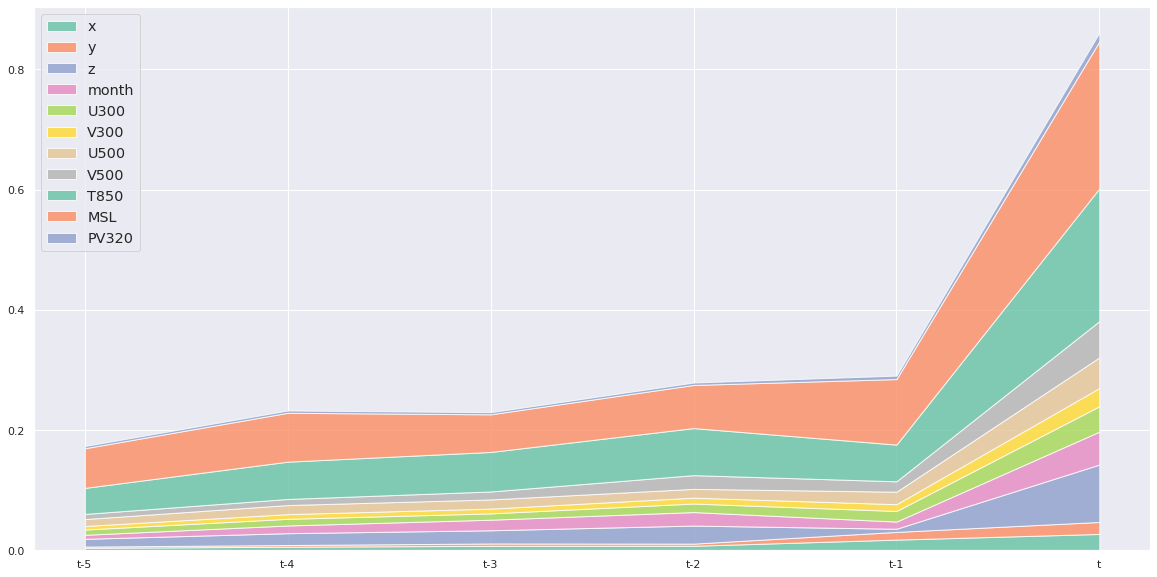

In [41]:
# plot stream graph over time
x = [f't-{5-i}' if i < 5 else 't' for i in range(6)]

f_names = ['x', 'y', 'z', 'month', 'U300', 'V300', 'U500', 'V500', 'T850', 'MSL', 'PV320']
# use a known color palette
pal = sns.color_palette("Set2", 12)
plt.figure(figsize=(20, 10))
plt.stackplot(x, f_imp.T[1:, :], labels = f_names, colors=pal, alpha=0.8 )
plt.legend(loc='upper left', fontsize = 'large')
plt.show()

In [94]:
def SHAP_ra(feature_id, shap_abs):
  """Plot the importance of ra_cols[feature_id] over time to the prediction of timestep (0 - 6)
  """
  ra_cols = ['U300', 'V300', 'U500', 'V500', 'T850', 'MSL', 'PV320']
  for timestep in range(6):
    sum_t = np.mean(shap_abs[timestep],axis=0) if timestep == 0 else sum_t + np.mean(shap_abs[timestep],axis=0) # contribution to the prediction of timestep  
  sum_t /= 6
  sum_ra = sum_t[:, 15:].reshape(-1, 7, 11, 11) 
  fig, axn = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 10))
  cbar_ax = fig.add_axes([.91, .3, .03, .4])
  fig.suptitle(f'SHAP contribution of {ra_cols[feature_id]} to predict pmin', fontsize=16)

  for i, ax in enumerate(axn.flat):
      sns.heatmap(sum_ra[i][feature_id], ax=ax,
                  cbar=i == 0,
                  vmin=0, 
                  vmax=np.max(sum_ra[:, feature_id]),
                  cbar_ax=None if i else cbar_ax)
      ax.set_xlabel(f'Time t-{str(5 - i)}' if i < 5 else f'Time t')

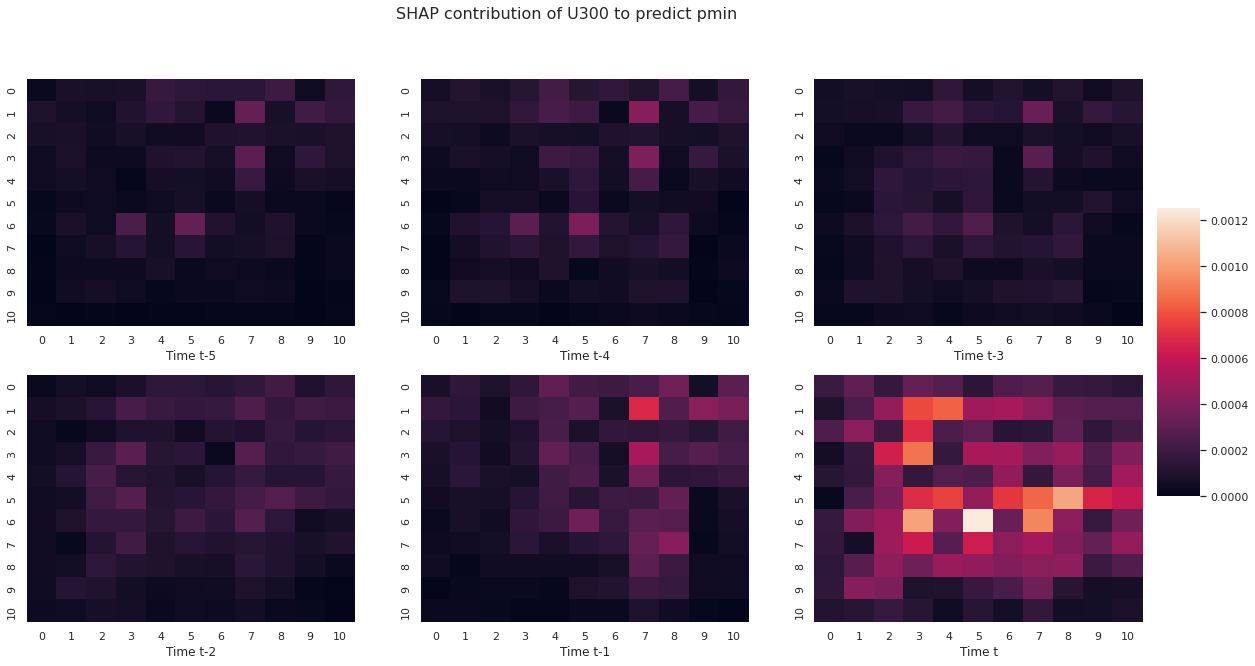

In [95]:
SHAP_ra(feature_id = 0, shap_abs = shap_abs)

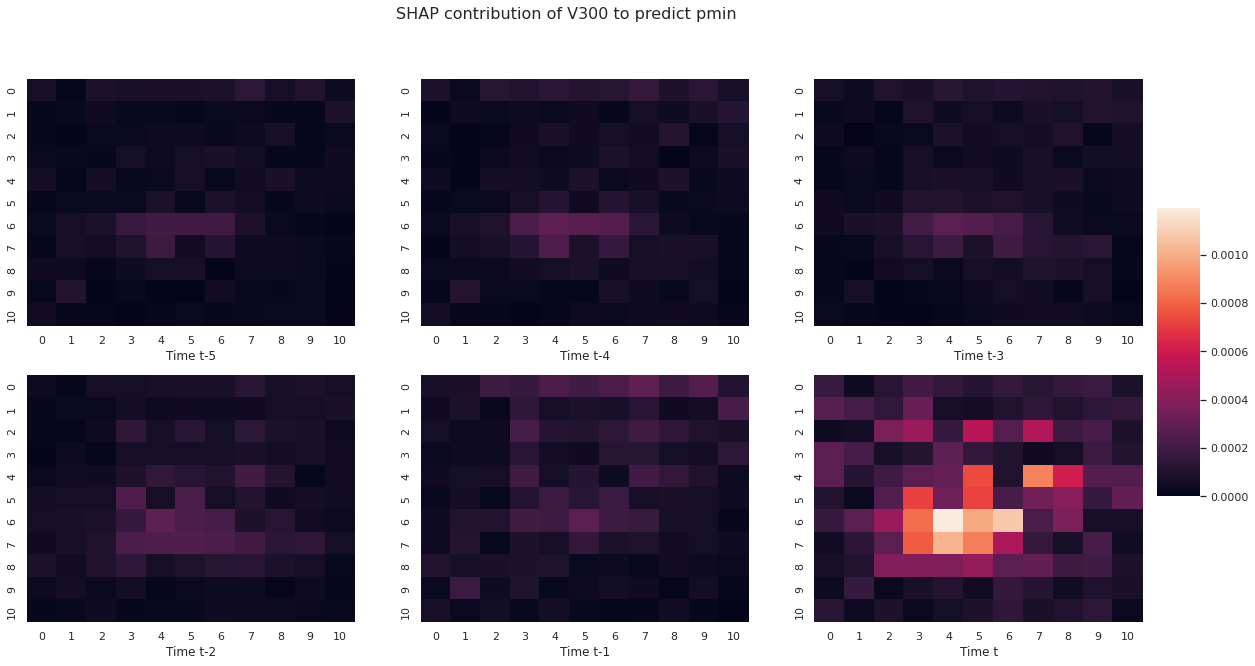

In [96]:
SHAP_ra(feature_id = 1, shap_abs = shap_abs)

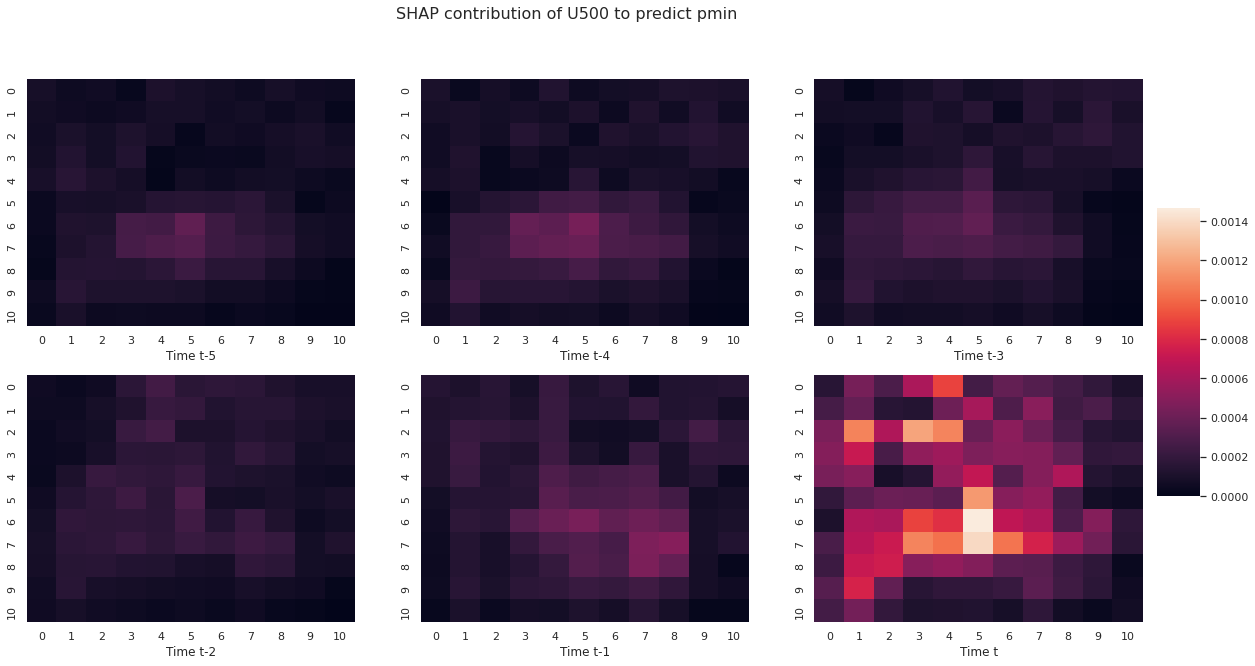

In [97]:
SHAP_ra(feature_id = 2, shap_abs = shap_abs)

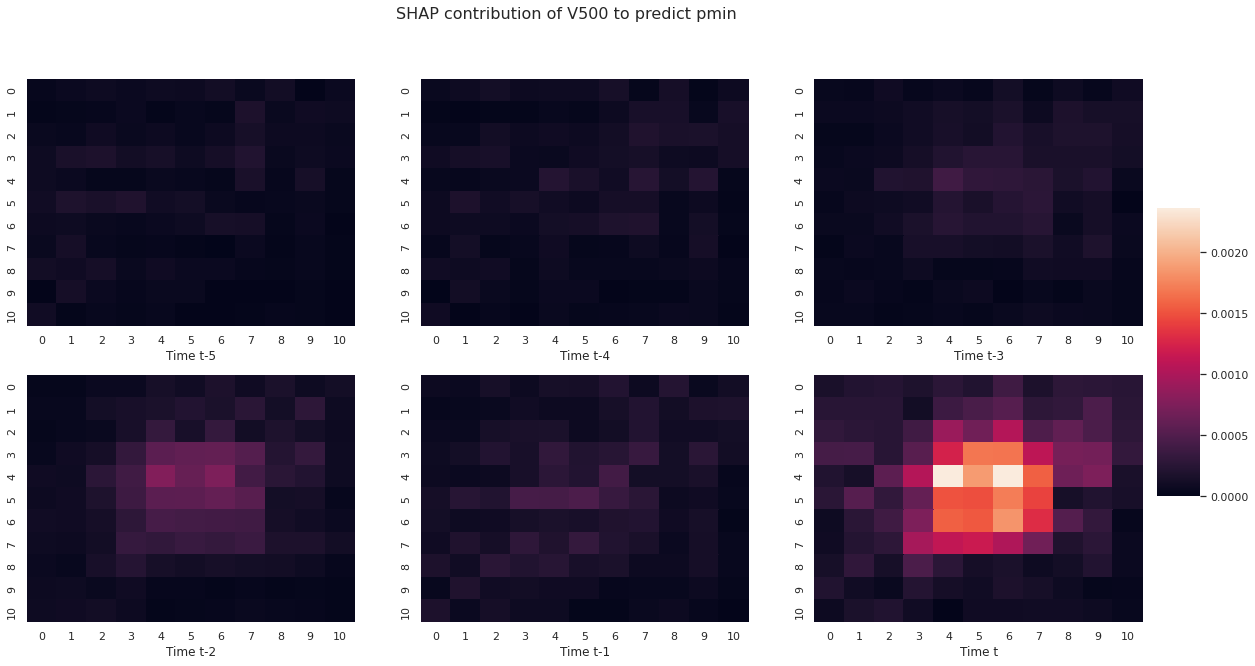

In [98]:
SHAP_ra(feature_id = 3, shap_abs = shap_abs)

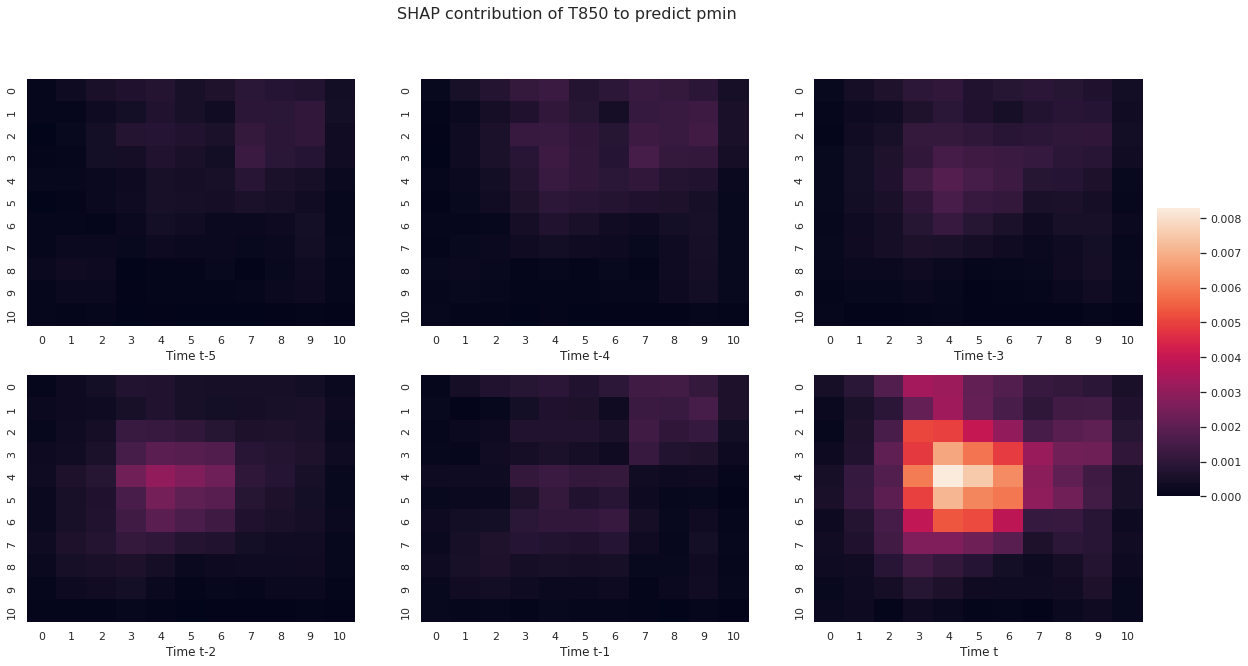

In [99]:
SHAP_ra(feature_id = 4, shap_abs = shap_abs)

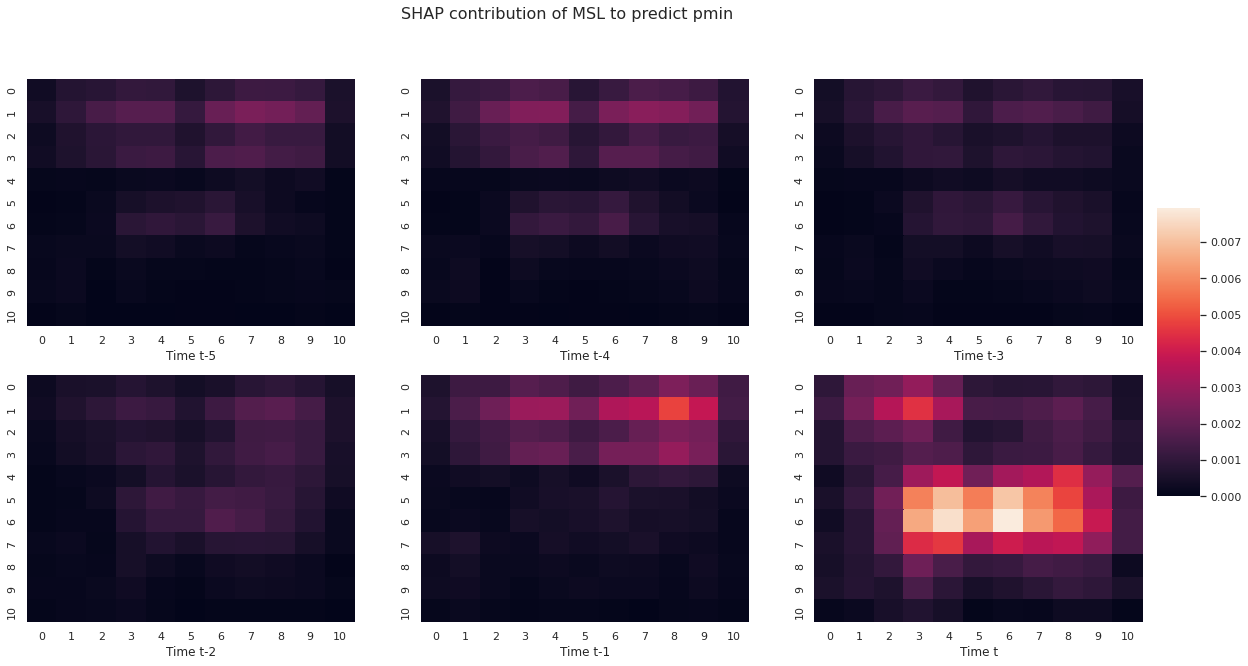

In [100]:
SHAP_ra(feature_id = 5, shap_abs = shap_abs)

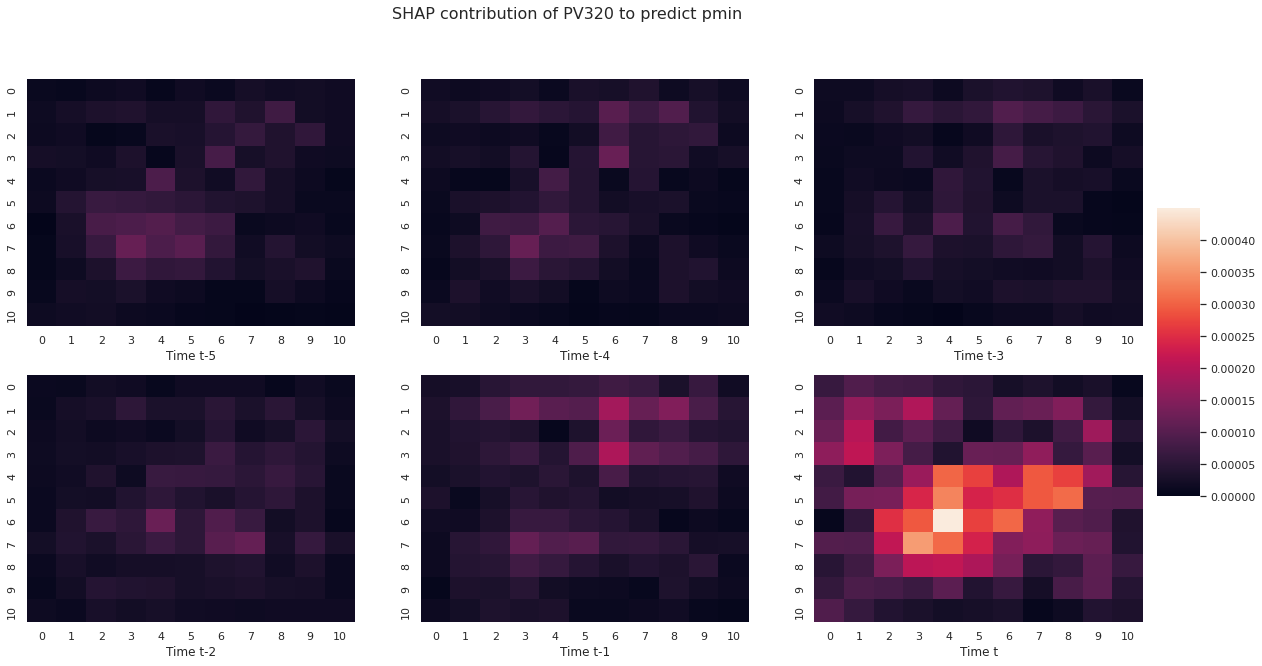

In [101]:
SHAP_ra(feature_id = 6, shap_abs = shap_abs)